In [514]:
import numpy as np
import pandas as pd
from math import pi, cos, sin
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import vaex
import h3
import geopandas
from shapely.geometry.polygon import Polygon
from shapely.geometry.point import Point
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import mapclassify


## Data Preperation

In [515]:
#loading prepared data
df_original = vaex.open('./data/trips_prepared.hdf5')

In [516]:
#make important changes to prepare for clustering
df = df_original.copy()

#add month, weekday, and hour columns
df['month'] = df.trip_start_timestamp.dt.month
df['weekday'] = df.trip_start_timestamp.dt.dayofweek
df['hour'] = df.trip_start_timestamp.dt.hour


In [517]:
#hour and day need to be recalculated as circular features in order to ensure the correct distances between each hour/day

def circular( dataframe, feature, name, n):
    dataframe[name + '_sin'] = feature.apply(lambda x: sin(2*pi*(x/n)))
    dataframe[name + '_cos'] = feature.apply(lambda x: cos(2*pi*(x/n)))

circular(df, df['weekday'], 'day', 7)
circular(df, df['hour'], 'hour', 24)

In [ ]:
#look at data for potential outliers
df.describe()

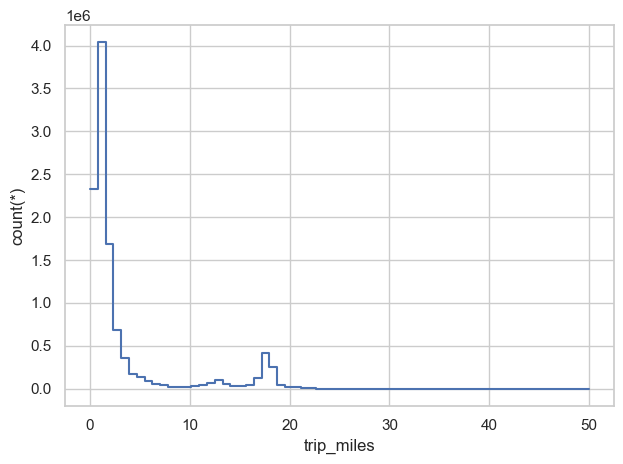

In [518]:
#huge outliers in distance
df.viz.histogram(df.trip_miles, limits=[0,50])

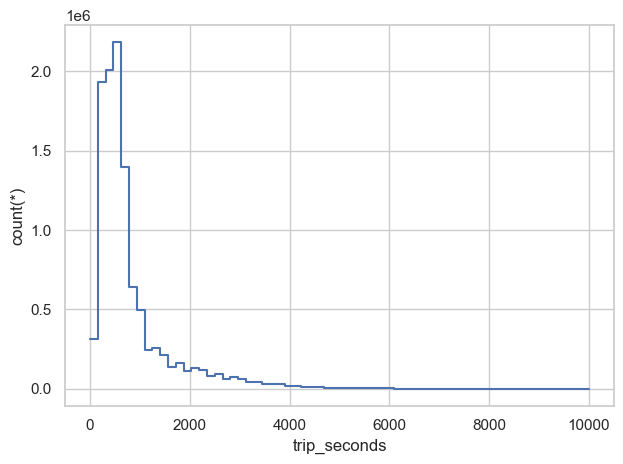

In [519]:
#huge outliers in duration
df.viz.histogram(df.trip_seconds, limits=[0,10000])

In [520]:
#99.9 percent of data lies between 0 miles and 20.4 miles
print("99% confidence miles:", df.limits_percentage('trip_miles', 99))
#99.9 percent of data lies between 128 seconds and 3061 seconds
print("99% confidence duration:", df.limits_percentage('trip_seconds', 99))

99% confidence miles: [ 0.03270182 20.41575204]
99% confidence duration: [  62.34481492 4381.56693522]


In [521]:
#lets take a look at the actual numbers of outliers here
df.select(df.trip_miles > 20.4)
print(len(df.evaluate(df.trip_miles, selection=True)))
df.select(df.trip_seconds < 62.34 and df.trip_seconds > 4381.57)
print(len(df.evaluate(df.trip_seconds, selection=True)))

53882
54724


In [522]:
#fewer than 55.000 rides had been longer than 20 miles therfore we discard those in order to avoid outlier bias
df= df[df['trip_miles'] < 20.41575204]
#Lets take a look at the remaining outliers data regarding the duration
df.select(df.trip_seconds < 62.34 and df.trip_seconds > 4381.57)
print(len(df.evaluate(df.trip_seconds, selection=True)))

46267


In [523]:
#discard remaining 46000 entries that are outside of the 99% intervall of the data regarding the duration
df= df[df['trip_seconds'] > 62.34481492] 
df= df[df['trip_seconds'] < 4381.56693522 ]

In [53]:
#look at data again
df.describe()

,trip_seconds,trip_miles,fare,tips,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,month,weekday,hour,day_sin,day_cos,hour_sin,hour_cos
data_type,float64,float64,float64,float64,string,string,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64
count,10806200,10806200,10806200,10806200,10806200,10806200,10806200,10806200,10806200,10806200,10806200,10806200,10806200,10806200,10806200,10806200,10806200
NA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mean,776.071445559031,3.2519452508714908,12.368325349336505,1.6541812931462858,--,--,41.89203749759779,-87.64874826338455,41.892632958242,-87.64401249339863,6.443291721419185,2.8727346338213247,14.091633599230072,0.07485323704750732,-0.09517895345263755,-0.2866083452437034,-0.2258114309680046
std,696.833266,4.903457,19.482874,2.661737,--,--,0.029893,0.066525,0.027195,0.053743,3.324975,1.845939,5.524534,0.693036,0.710661,0.651168,0.665466
min,63.0,0.01,0.0,0.0,--,--,41.717967,-87.90304,41.683404,-87.90304,1,0,0,-0.974928,-0.900969,-1.0,-1.0
max,4381.0,20.41,9280.82,311.18,--,--,42.021224,-87.573952,42.021224,-87.531386,12,6,23,0.974928,1.0,1.0,1.0


In [525]:
#add weekend column to dataset
df['weekend'] = df['weekday'].apply(lambda x: 1 if x > 4 else 0)

In [528]:
#dropping unneccessary columns and finishing dataframe
df_loc = df.copy()
df.drop(columns = ['trip_id', 'taxi_id','trip_start_timestamp', 'trip_end_timestamp', 'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area', 'dropoff_community_area', 'tolls', 'extras', 'trip_total',  'trip_start_hour',    'trip_end_hour',    'trip_start_4h_period',    'trip_end_4h_period'  ], inplace=True)
df.head(1)

#,trip_seconds,trip_miles,fare,tips,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,month,weekday,hour,day_sin,day_cos,hour_sin,hour_cos,weekend
0,240,1.3,6.25,0,Cash,Taxi Affiliation Services,41.881,-87.6327,41.8853,-87.6572,1,6,0,-0.781831,0.62349,0,1,1


In [526]:
#scaling method for variables that need scaling
scaler = StandardScaler()

def scaling(data):
    scaler.fit(data)
    data_scaled = scaler.transform(data)
    df_data_scaled = pd.DataFrame(data_scaled, columns = data.get_column_names())
    return data_scaled, df_data_scaled

In [527]:
#choose number of clusters for k-means

def k_optimal(data, k_max):
    clusters = []
    losses = []
    for k in range(k_max):
        model= MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++") 
        model.fit(data)
        clusters.append(k+1)
        losses.append(model.inertia_)
    plt.plot(clusters, losses)
        #plt.xlim([2,10])
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.show()

### CLUSTERING OF TRIP TYPES 

In [530]:
#preparing dataframes for weekend and weekdays data
features = ['fare', 'tips','payment_type', 'company', 'pickup_centroid_latitude', 'pickup_centroid_longitude','dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'trip_seconds']
df_cluster = df.drop(columns = features)
df_cluster_one = df_cluster[df_cluster['weekend'] == 0]
df_cluster_two = df_cluster[df_cluster['weekend'] == 1]

In [531]:
#scaling variables that need scaling for weekdays data
features = ['month', 'weekday', 'hour', 'weekend']

df_cluster_one_scaling = df_cluster_one.drop(columns = features)

cluster_one_scaled, df_cluster_one_scaled =  scaling(df_cluster_one_scaling)

df_cluster_one_scaled = vaex.from_pandas(df_cluster_one_scaled)

In [532]:
#scaling variables that need scaling for weekends data
features = ['month', 'weekday', 'hour', 'weekend']

df_cluster_two_scaling = df_cluster_two.drop(columns = features)

cluster_two_scaled, df_cluster_two_scaled =  scaling(df_cluster_two_scaling)

df_cluster_two_scaled = vaex.from_pandas(df_cluster_two_scaled)

In [543]:
weekdays_df = df_cluster_one_scaled.copy()
weekends_df = df_cluster_two_scaled.copy()

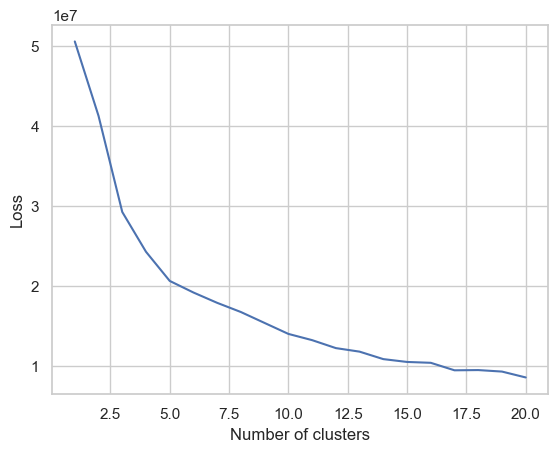

In [147]:
#choose number of clusters for k-means weekdays

k_optimal(weekdays_df, 20)

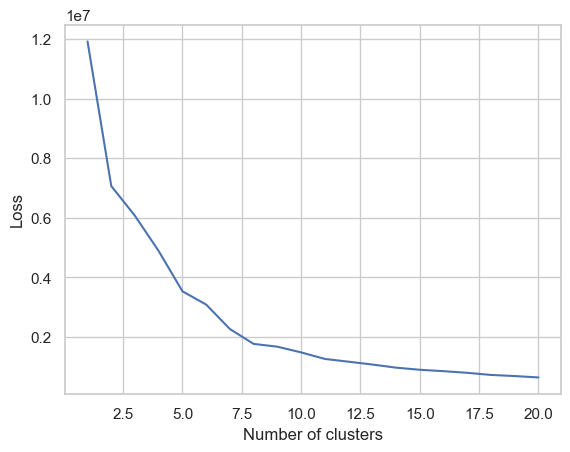

In [164]:
#choose number of clusters for k-means weekends

k_optimal(weekends_df, 20)

In [534]:
#after trying aout several clusters between 3 and 7 we achieved the best results with 5 cluster centers
amount_clusters = 5

In [544]:
# k-mean++ clustering and gmm weekdays

#fit models
means = KMeans(n_clusters=amount_clusters, random_state=42,init="k-means++")
means.fit(weekdays_df)
gmm = GaussianMixture(n_components = amount_clusters, random_state=42)
gmm.fit(weekdays_df)

numbers = ['one', 'two', 'three', 'four', 'five', 'six']
#predict clusters
kmeans_labels = means.predict(weekdays_df)
gmm_labels = gmm.predict(weekdays_df)

weekdays_df["kmeans_cluster"] = means.predict(weekdays_df)
weekdays_df["kmeans_cluster"] = weekdays_df["kmeans_cluster"].apply(lambda x: numbers[x])

weekdays_df["gmm_cluster"] = gmm.predict(weekdays_df)
weekdays_df["gmm_cluster"] = weekdays_df["gmm_cluster"].apply(lambda x: numbers[x])


/Users/tim/opt/anaconda3/envs/AAproject/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- __kmeans_cluster
Feature names must be in the same order as they were in fit.

  Parameters


In [545]:
# k-mean++ clustering and gmm weekends

#fit models
means = KMeans(n_clusters=5, random_state=42,init="k-means++")
means.fit(weekends_df)
gmm = GaussianMixture(n_components = 5, random_state=42)
gmm.fit(weekends_df)

numbers = ['one', 'two', 'three', 'four', 'five', 'six']
#predict clusters
kmeans_labels = means.predict(weekends_df)
gmm_labels = gmm.predict(weekends_df)

weekends_df["kmeans_cluster"] = means.predict(weekends_df)
weekends_df["kmeans_cluster"] = weekends_df["kmeans_cluster"].apply(lambda x: numbers[x])

weekends_df["gmm_cluster"] = gmm.predict(weekends_df)
weekends_df["gmm_cluster"] = weekends_df["gmm_cluster"].apply(lambda x: numbers[x])


/Users/tim/opt/anaconda3/envs/AAproject/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- __kmeans_cluster
Feature names must be in the same order as they were in fit.

  Parameters


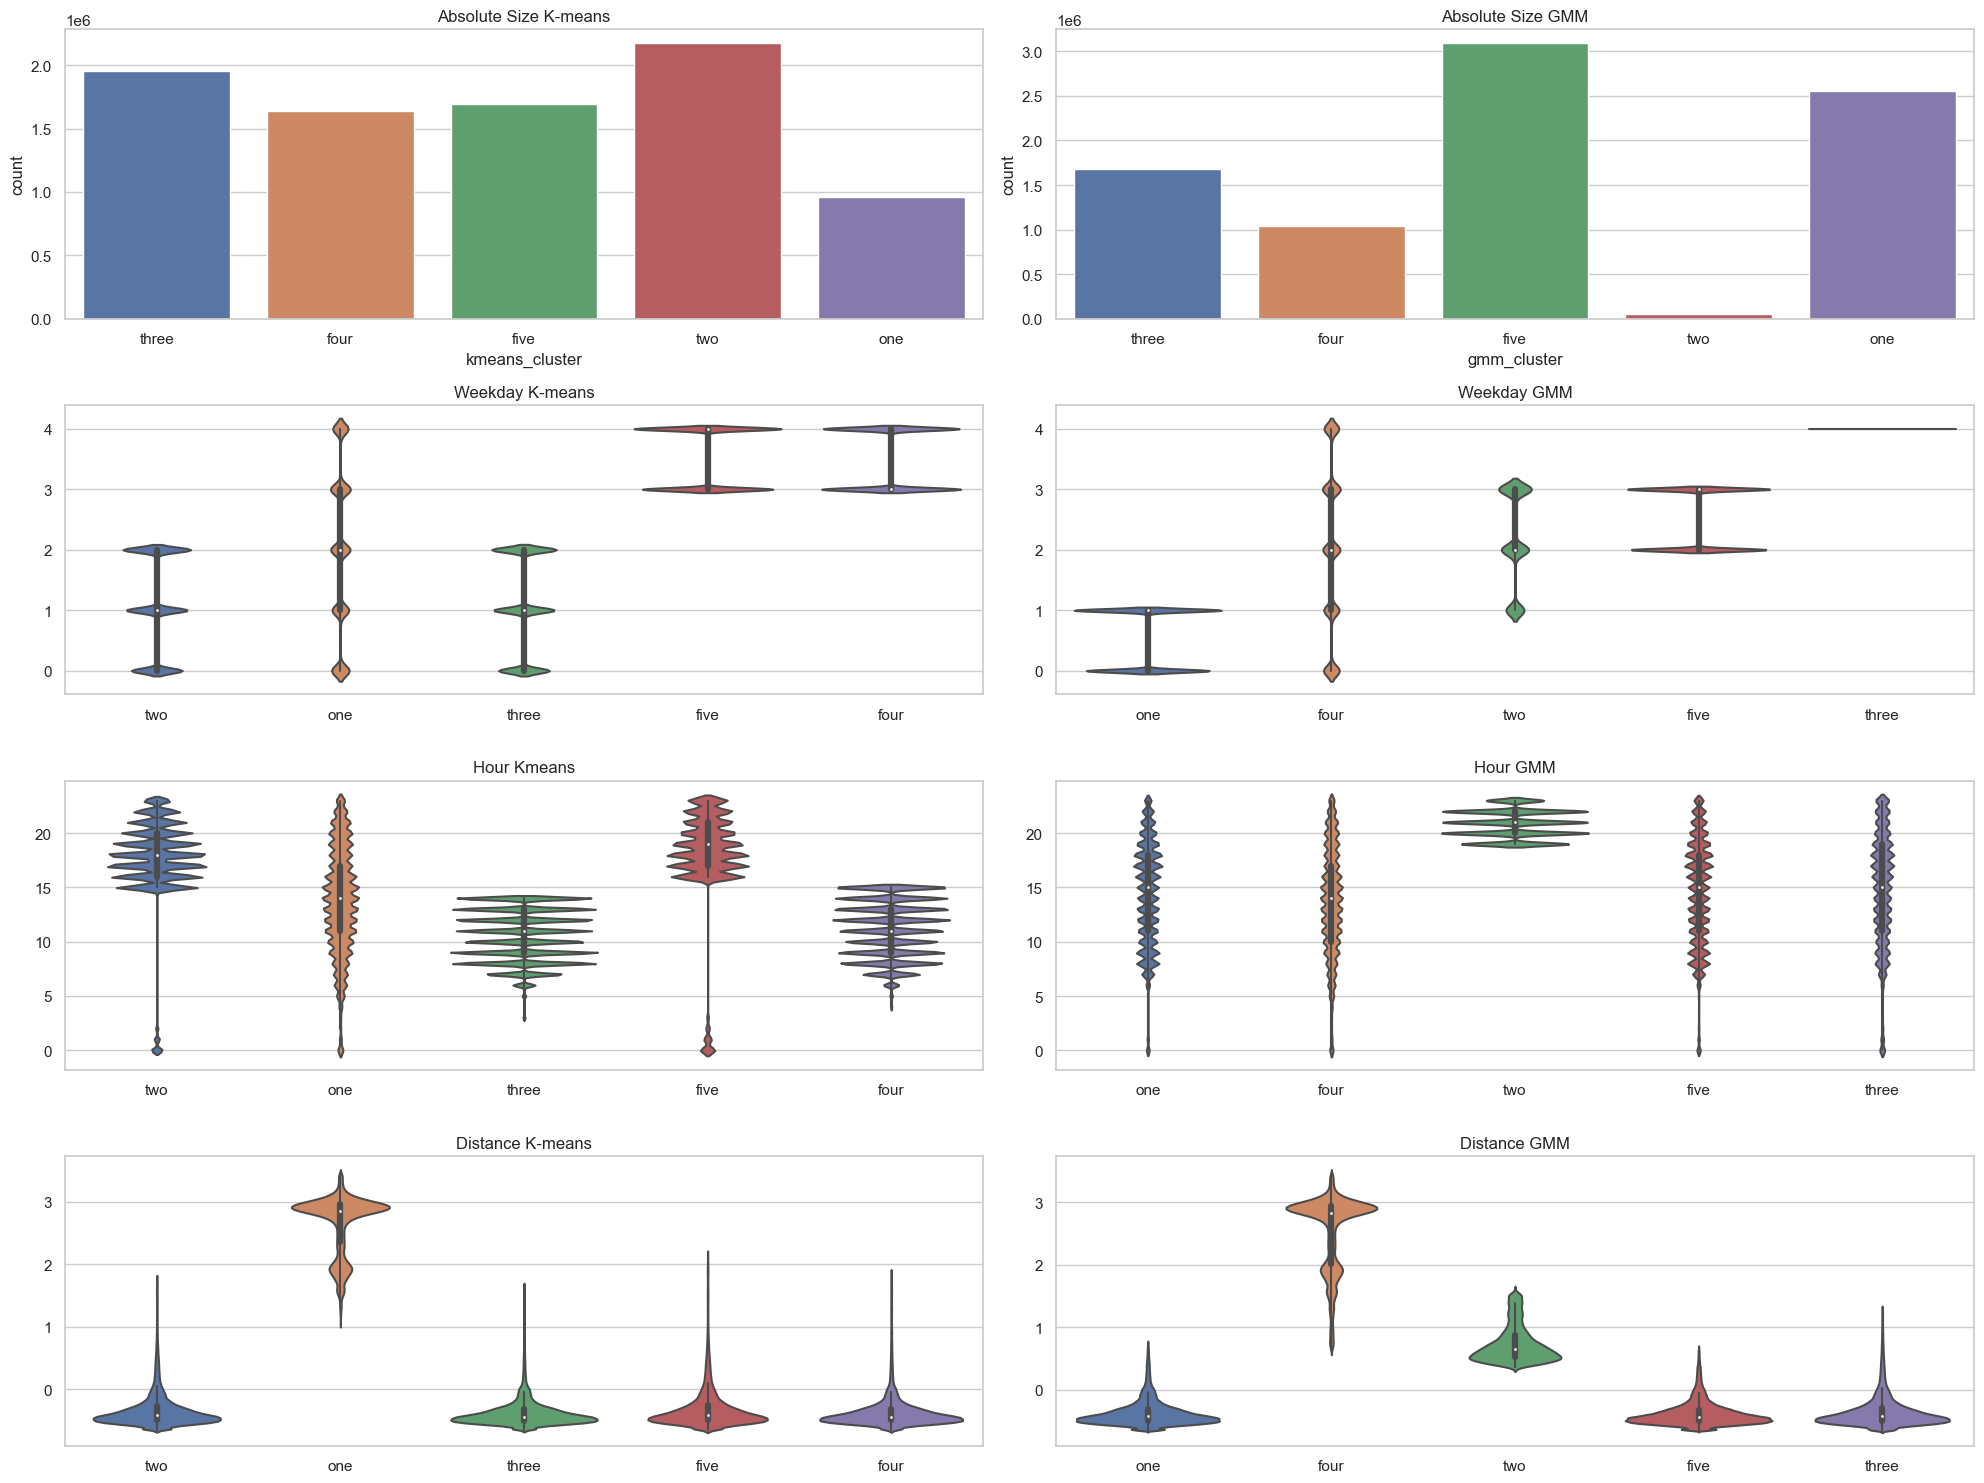

In [546]:
df_dummy = df_cluster_one.drop(columns = ['trip_miles', 'hour_sin','hour_cos', 'day_cos', 'day_sin'])
weekdays_df = weekdays_df.join(df_dummy, allow_duplication=True)

cluster_size_weekdays_kmeans = pd.DataFrame(weekdays_df.groupby(weekdays_df['kmeans_cluster'], agg='count').to_dict())
cluster_size_weekdays_gmm = pd.DataFrame(weekdays_df.groupby(weekdays_df['gmm_cluster'], agg='count').to_dict())

plots, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20,15))

sns.barplot(ax = axes[0,0], x='kmeans_cluster', y='count', data=cluster_size_weekdays_kmeans)
sns.barplot(ax = axes[0,1], x='gmm_cluster', y='count', data=cluster_size_weekdays_gmm)
sns.violinplot(ax = axes[1, 0], x=weekdays_df['kmeans_cluster'].values, y=weekdays_df.weekday.values)
sns.violinplot(ax = axes[1, 1], x=weekdays_df['gmm_cluster'].values, y=weekdays_df.weekday.values)
sns.violinplot(ax = axes[2, 0], x=weekdays_df['kmeans_cluster'].values, y=weekdays_df.hour.values)
sns.violinplot(ax = axes[2, 1], x=weekdays_df['gmm_cluster'].values, y=weekdays_df.hour.values)
sns.violinplot(ax = axes[3, 0], x=weekdays_df['kmeans_cluster'].values, y=weekdays_df.trip_miles.values)
sns.violinplot(ax = axes[3, 1], x=weekdays_df['gmm_cluster'].values, y=weekdays_df.trip_miles.values)



axes[0, 0].set_title('Absolute Size K-means'), axes[0, 1].set_title('Absolute Size GMM'), axes[1, 0].set_title('Weekday K-means'), axes[1, 1].set_title('Weekday GMM'), axes[2, 0].set_title('Hour Kmeans'), axes[2, 1].set_title('Hour GMM'), axes[3, 0].set_title('Distance K-means'), axes[3, 1].set_title('Distance GMM')

plots.tight_layout()
plt.show()

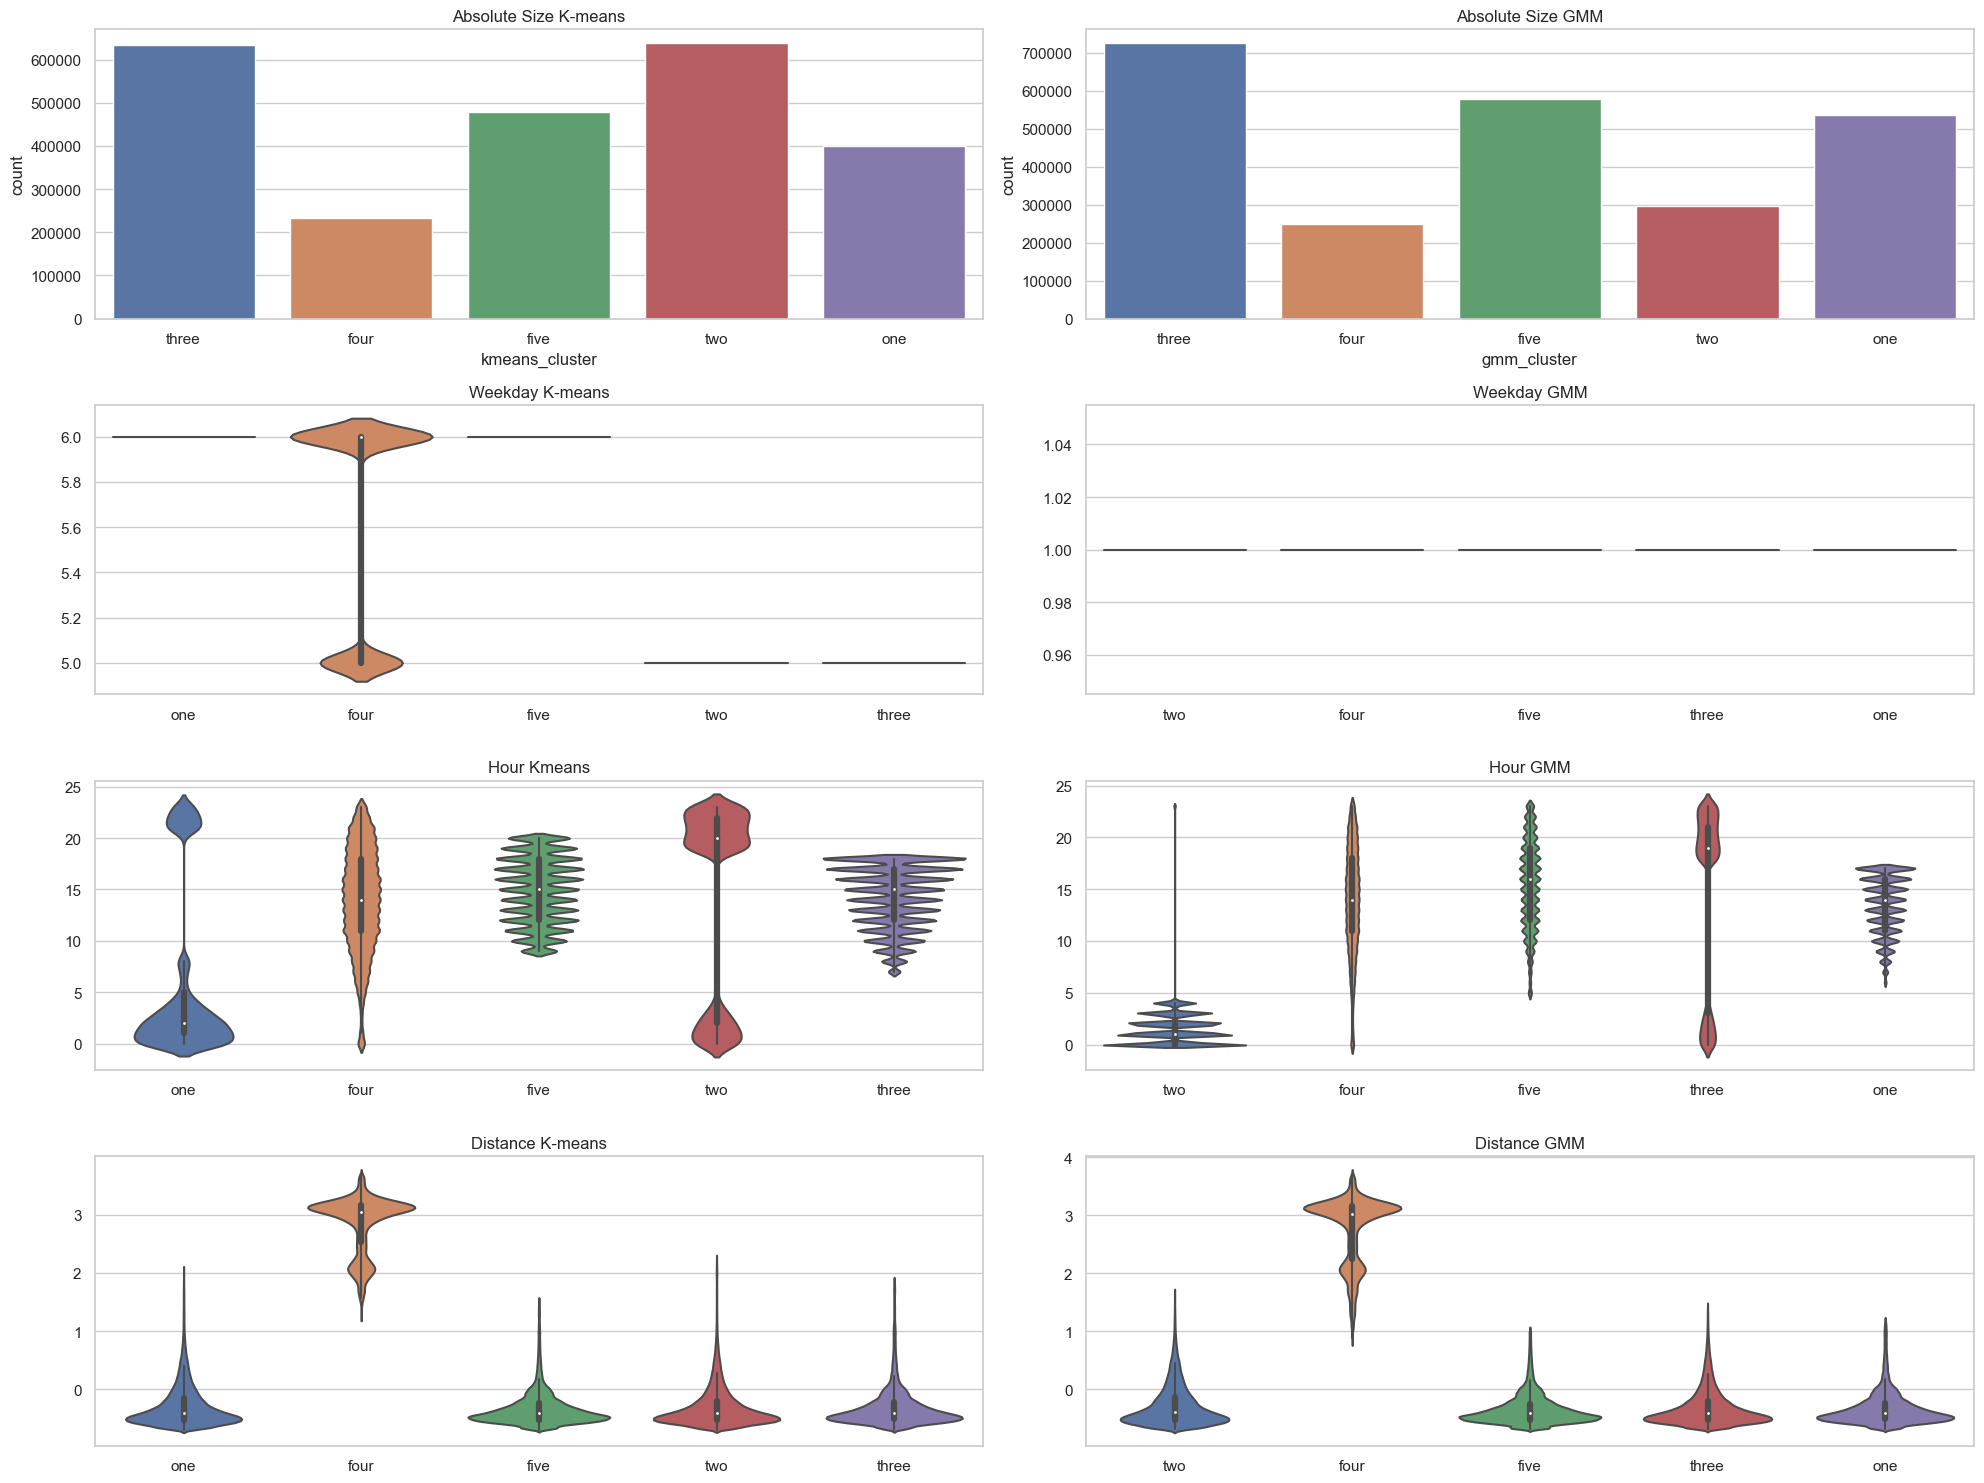

In [547]:
df_dummy = df_cluster_two.drop(columns = ['trip_miles', 'hour_sin','hour_cos', 'day_cos', 'day_sin'])
weekends_df = weekends_df.join(df_dummy, allow_duplication=True)

cluster_size_weekends_kmeans = pd.DataFrame(weekends_df.groupby(weekends_df['kmeans_cluster'], agg='count').to_dict())
cluster_size_weekends_gmm = pd.DataFrame(weekends_df.groupby(weekends_df['gmm_cluster'], agg='count').to_dict())

plots, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20,15))

sns.barplot(ax = axes[0,0], x='kmeans_cluster', y='count', data=cluster_size_weekends_kmeans)
sns.barplot(ax = axes[0,1], x='gmm_cluster', y='count', data=cluster_size_weekends_gmm)
sns.violinplot(ax = axes[1, 0], x=weekends_df['kmeans_cluster'].values, y=weekends_df.weekday.values)
sns.violinplot(ax = axes[1, 1], x=weekends_df['gmm_cluster'].values, y=weekends_df.weekend.values)
sns.violinplot(ax = axes[2, 0], x=weekends_df['kmeans_cluster'].values, y=weekends_df.hour.values)
sns.violinplot(ax = axes[2, 1], x=weekends_df['gmm_cluster'].values, y=weekends_df.hour.values)
sns.violinplot(ax = axes[3, 0], x=weekends_df['kmeans_cluster'].values, y=weekends_df.trip_miles.values)
sns.violinplot(ax = axes[3, 1], x=weekends_df['gmm_cluster'].values, y=weekends_df.trip_miles.values)



axes[0, 0].set_title('Absolute Size K-means'), axes[0, 1].set_title('Absolute Size GMM'), axes[1, 0].set_title('Weekday K-means'), axes[1, 1].set_title('Weekday GMM'), axes[2, 0].set_title('Hour Kmeans'), axes[2, 1].set_title('Hour GMM'), axes[3, 0].set_title('Distance K-means'), axes[3, 1].set_title('Distance GMM')

plots.tight_layout()
plt.show()

## Clustering Locations

In [637]:
df_location = df_loc.copy()

In [636]:
def convert_to_h3(lat,long):
    return h3.geo_to_h3(lat, long, 8)

In [638]:
#adding hexagon information for clustering
df_location['pickup_hex'] = df_location.apply(convert_to_h3, [df_location['pickup_centroid_latitude'], df_location['pickup_centroid_longitude']])
df_location['dropoff_hex'] = df_location.apply(convert_to_h3, [df_location['dropoff_centroid_latitude'], df_location['dropoff_centroid_longitude']])

# Lets first look on the start locations

In [639]:
#preparing dataframe and cound the number of occurences at every pickup cencus tract per each hour of a day
df_location_start = df_location[['pickup_hex', 'trip_start_hour', 'weekday']]
df_location_start = df_location_start[df_location_start['weekday'] < 5]
df_location_start.drop(columns = ['weekday'], inplace = True)
df_location_start_pd = pd.DataFrame(df_location_start.to_dict())
df_location_start_pd.rename(columns = {0: 'pickup_hex', 1: 'trip_start_hour'}, inplace = True)
df_location_start_pd.loc[:,"hour"] = df_location_start_pd['trip_start_hour'].apply(lambda x: np.trunc(x))
df_location_start_pd = df_location_start_pd.groupby(['trip_start_hour', 'pickup_hex']).size().unstack()
df_location_start_pd = df_location_start_pd.fillna(0) #fill NaN entrys with 0
df_location_start_pd


pickup_hex,8826645219fffff,8826645253fffff,882664c101fffff,882664c103fffff,882664c105fffff,882664c107fffff,882664c10dfffff,882664c115fffff,882664c117fffff,882664c121fffff,...,882664d9b3fffff,882664d9b5fffff,882664d9b7fffff,882664d9d7fffff,882759340bfffff,88275934edfffff,8827593697fffff,882759369bfffff,88275936b1fffff,88275936bbfffff
trip_start_hour,,,,,,,,,,,,,,,,,,,,,
0,3258.0,0.0,21.0,82.0,726.0,365.0,436.0,852.0,32.0,3.0,...,0.0,0.0,0.0,0.0,0.0,9529.0,0.0,0.0,1.0,0.0
1,1413.0,0.0,1.0,25.0,498.0,445.0,354.0,290.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3632.0,0.0,0.0,0.0,0.0
2,415.0,0.0,6.0,19.0,266.0,240.0,166.0,101.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,994.0,0.0,0.0,0.0,0.0
3,67.0,0.0,4.0,6.0,84.0,67.0,77.0,38.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,305.0,0.0,0.0,0.0,0.0
4,13.0,0.0,9.0,9.0,19.0,17.0,24.0,35.0,28.0,0.0,...,0.0,0.0,0.0,0.0,0.0,480.0,0.0,0.0,0.0,0.0
5,30.0,0.0,70.0,43.0,26.0,55.0,52.0,265.0,137.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1651.0,0.0,0.0,0.0,0.0
6,658.0,0.0,450.0,307.0,40.0,112.0,255.0,1158.0,1274.0,6.0,...,0.0,0.0,1.0,0.0,0.0,4102.0,0.0,1.0,3.0,0.0
7,3816.0,1.0,1751.0,1394.0,173.0,994.0,1048.0,2963.0,4133.0,6.0,...,0.0,0.0,0.0,0.0,1.0,6995.0,0.0,0.0,4.0,0.0
8,6737.0,0.0,3530.0,2491.0,454.0,2505.0,2102.0,4722.0,6220.0,5.0,...,1.0,1.0,1.0,0.0,0.0,14404.0,0.0,0.0,1.0,0.0


In [640]:
#prepare vaex dataframe from pandas dataframe
df_location_start = vaex.from_pandas(df_location_start_pd)
df_location_start

#scaling data
location_start_scaled, df_location_start_scaled = scaling(df_location_start)

#transpose data to have more convenient visualization
location_start_scaled_trans = location_start_scaled.transpose()
df_location_start_scaled_trans = df_location_start_scaled.transpose()
df_k_optimal = df_location_start_scaled_trans.copy()

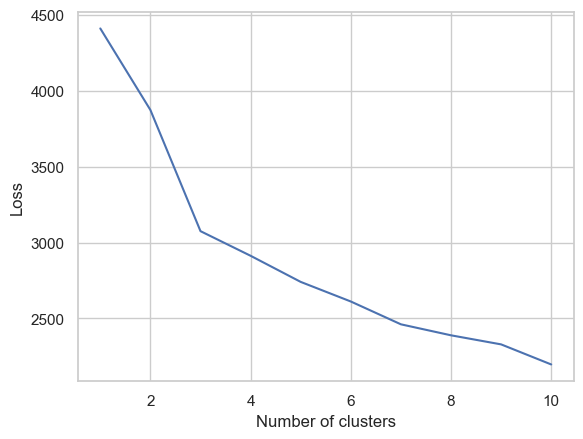

In [641]:
#choose number of cluster centers 

k_optimal(df_k_optimal, 10)

In [642]:
number_components = 3

In [659]:
#apply k-means++ and gmm
df_clustering = df_location_start_scaled_trans.copy()
means = KMeans(n_clusters=number_components, random_state=42,init="k-means++")
means.fit(df_clustering)
gmm = GaussianMixture(n_components = number_components, random_state = 42)
gmm.fit(df_clustering)

numbers_kmeans = ['latenight rides', 'morning rides', 'midday/afternoon rides', 'four', 'five', 'six']
numbers_gmm = ['latenight rides', 'morning rides', 'midday/afternoon rides', 'four', 'five', 'six']

#add cluster lables to the dataset
df_cluster_kmeans = means.predict(location_start_scaled_trans)
df_cluster_gmm = gmm.predict(location_start_scaled_trans)

df_clustering["kmeans_cluster"] = df_cluster_kmeans
df_clustering["kmeans_cluster"] = df_clustering["kmeans_cluster"].apply(lambda x: numbers_kmeans[x])
df_clustering["gmm_cluster"] = df_cluster_gmm
df_clustering["gmm_cluster"] = df_clustering["gmm_cluster"].apply(lambda x: numbers_gmm[x])



In [665]:
cluster_sizes_kmeans = df_clustering.groupby(['kmeans_cluster'])['kmeans_cluster'].agg('count')
cluster_sizes_gmm = df_clustering.groupby(['gmm_cluster'])['gmm_cluster'].agg('count')
print(cluster_sizes_kmeans)
print(cluster_sizes_gmm)

kmeans_cluster
latenight rides           68
midday/afternoon rides    78
morning rides             67
Name: kmeans_cluster, dtype: int64
gmm_cluster
latenight rides           70
midday/afternoon rides    57
morning rides             86
Name: gmm_cluster, dtype: int64


In [661]:
#sort stations into respective cluster dataframes
df_stations_one = df_clustering.loc[df_clustering['kmeans_cluster'] == 'latenight rides']
df_stations_two = df_clustering.loc[df_clustering['kmeans_cluster'] == 'morning rides']
df_stations_three = df_clustering.loc[df_clustering['kmeans_cluster'] == 'midday/afternoon rides']
#df_stations_four = df_clustering.loc[df_clustering['kmeans_cluster'] == 'four']

#gmm
df_stations_one_gmm = df_clustering.loc[df_clustering['gmm_cluster'] == 'latenight rides']
df_stations_two_gmm = df_clustering.loc[df_clustering['gmm_cluster'] == 'morning rides']
df_stations_three_gmm = df_clustering.loc[df_clustering['gmm_cluster'] == 'midday/afternoon rides']
#df_stations_four_gmm = df_clustering.loc[df_clustering['gmm_cluster'] == 'four']

#drop the cluster column as its not needed anymore
df_stations_one = df_stations_one.drop(['kmeans_cluster','gmm_cluster'], axis = 1)
df_stations_two = df_stations_two.drop(['kmeans_cluster','gmm_cluster'], axis = 1)
df_stations_three = df_stations_three.drop(['kmeans_cluster','gmm_cluster'], axis = 1)
#df_stations_four = df_stations_four.drop(['kmeans_cluster','gmm_cluster'], axis = 1)

#gmm
df_stations_one_gmm = df_stations_one_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)
df_stations_two_gmm = df_stations_two_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)
df_stations_three_gmm = df_stations_three_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)
#df_stations_four_gmm = df_stations_four_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)

#transpose and calculate average over every hour of the day 
df_stations_one = df_stations_one.transpose()
df_stations_two = df_stations_two.transpose()
df_stations_three = df_stations_three.transpose()
#df_stations_four = df_stations_four.transpose()

df_stations_one['average'] = df_stations_one.mean(numeric_only = True, axis = 1)
df_stations_two['average'] = df_stations_two.mean(numeric_only = True, axis = 1)
df_stations_three['average'] = df_stations_three.mean(numeric_only = True, axis = 1)
#df_stations_four['average'] = df_stations_four.mean(numeric_only = True, axis = 1)

#gmm
df_stations_one_gmm = df_stations_one_gmm.transpose()
df_stations_two_gmm = df_stations_two_gmm.transpose()
df_stations_three_gmm = df_stations_three_gmm.transpose()
#df_stations_four_gmm = df_stations_four_gmm.transpose()

df_stations_one_gmm['average'] = df_stations_one_gmm.mean(numeric_only = True, axis = 1)
df_stations_two_gmm['average'] = df_stations_two_gmm.mean(numeric_only = True, axis = 1)
df_stations_three_gmm['average'] = df_stations_three_gmm.mean(numeric_only = True, axis = 1)
#df_stations_four_gmm['average'] = df_stations_four_gmm.mean(numeric_only = True, axis = 1)

(None,
 Text(0.5, 1.0, 'Cluster 3: midday/afternoon rides'),
 Text(147.5, 0.5, 'Trips'),
 Text(0.5, 44.249999999999986, 'Start Hour'))

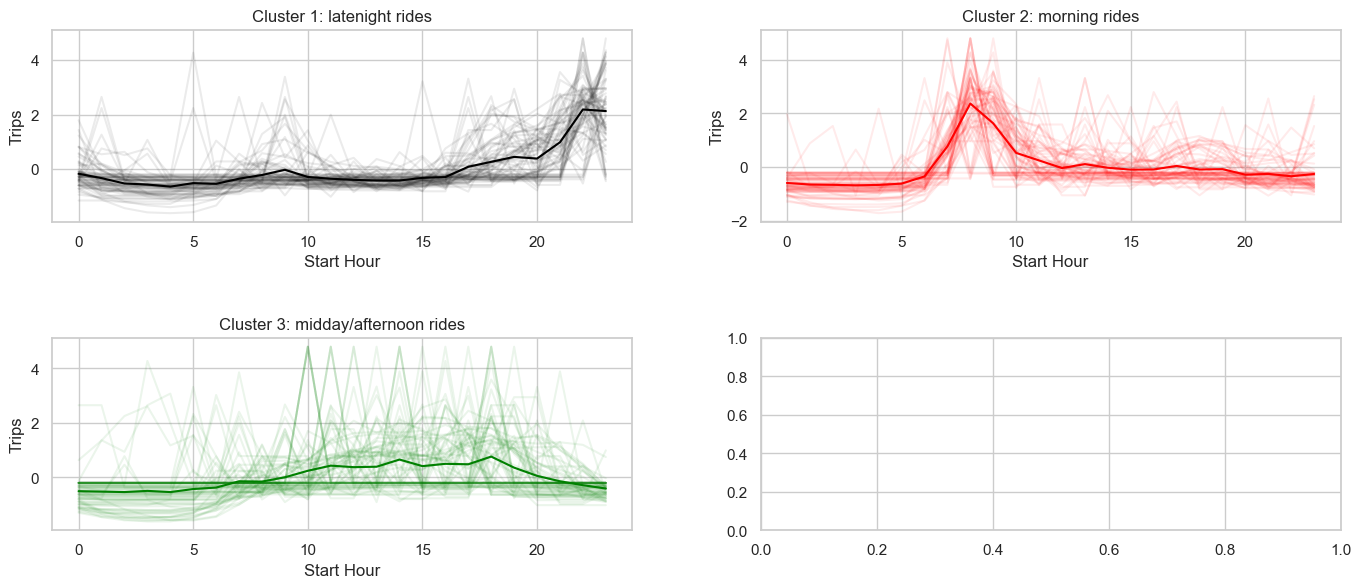

In [662]:
#plot the results kmeans
fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize=(15,7))
fig.tight_layout(pad = 5)

df_stations_one.plot(ax=ax[0,0],color='black', alpha=0.08)
df_stations_one["average"].plot(ax=ax[0,0],color='black', alpha=1)
ax[0,0].get_legend().remove(), ax[0,0].set_title('Cluster 1: latenight rides'), ax[0,0].set_ylabel('Trips'), ax[0,0].set_xlabel('Start Hour')

df_stations_two.plot(ax=ax[0,1],color='red', alpha=0.08)
df_stations_two["average"].plot(ax=ax[0,1],color='red', alpha=1)
ax[0,1].get_legend().remove(), ax[0,1].set_title('Cluster 2: morning rides'), ax[0,1].set_ylabel('Trips'), ax[0,1].set_xlabel('Start Hour')

df_stations_three.plot(ax=ax[1,0],color='green', alpha=0.08)
df_stations_three["average"].plot(ax=ax[1,0],color='green', alpha=1)
ax[1,0].get_legend().remove(), ax[1,0].set_title('Cluster 3: midday/afternoon rides'), ax[1,0].set_ylabel('Trips'), ax[1,0].set_xlabel('Start Hour')

#df_stations_four.plot(ax=ax[1,1],color='blue', alpha=0.08)
#df_stations_four["average"].plot(ax=ax[1,1],color='blue', alpha=1)
#ax[1,1].get_legend().remove(), ax[1,1].set_title('Cluster 3: Work/University\nArea'), ax[1,1].set_ylabel('Trips'), ax[1,1].set_xlabel('Start Hour')

(None,
 Text(0.5, 1.0, 'Cluster 3: midday/afternoon rides'),
 Text(147.5, 0.5, 'Trips'),
 Text(0.5, 44.249999999999986, 'Start Hour'))

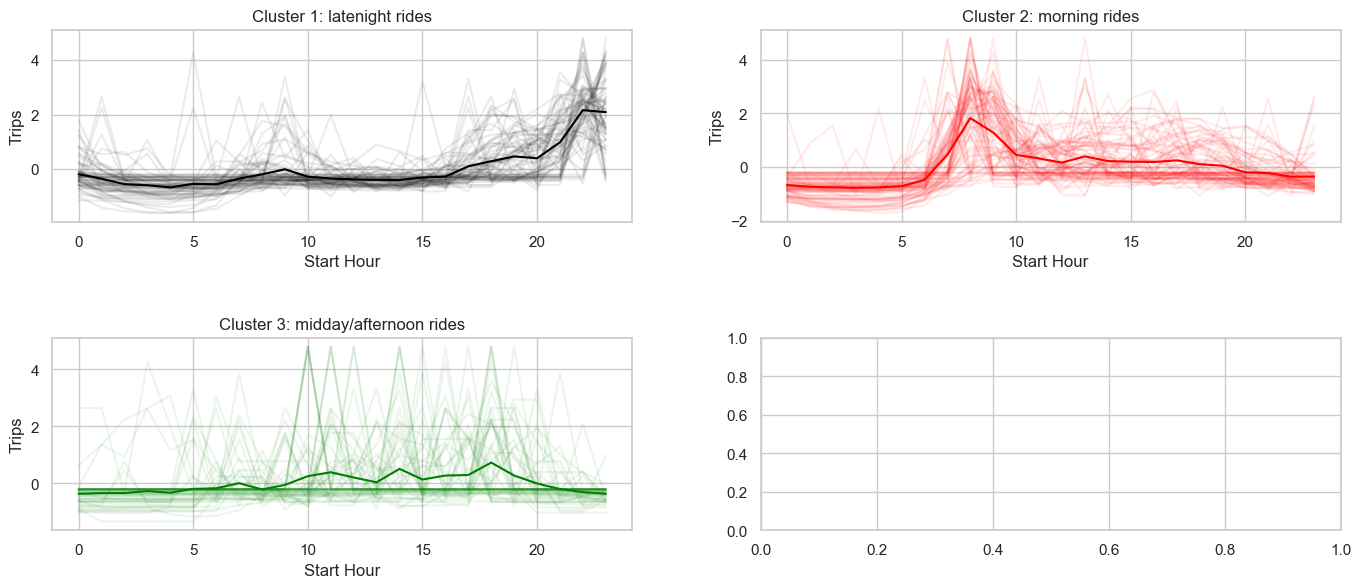

In [664]:
#plot the results gmm
fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize=(15,7))
fig.tight_layout(pad = 5)

df_stations_one_gmm.plot(ax=ax[0,0],color='black', alpha=0.08)
df_stations_one_gmm["average"].plot(ax=ax[0,0],color='black', alpha=1)
ax[0,0].get_legend().remove(), ax[0,0].set_title('Cluster 1: latenight rides'), ax[0,0].set_ylabel('Trips'), ax[0,0].set_xlabel('Start Hour')

df_stations_two_gmm.plot(ax=ax[0,1],color='red', alpha=0.08)
df_stations_two_gmm["average"].plot(ax=ax[0,1],color='red', alpha=1)
ax[0,1].get_legend().remove(), ax[0,1].set_title('Cluster 2: morning rides'), ax[0,1].set_ylabel('Trips'), ax[0,1].set_xlabel('Start Hour')

df_stations_three_gmm.plot(ax=ax[1,0],color='green', alpha=0.08)
df_stations_three_gmm["average"].plot(ax=ax[1,0],color='green', alpha=1)
ax[1,0].get_legend().remove(), ax[1,0].set_title('Cluster 3: midday/afternoon rides'), ax[1,0].set_ylabel('Trips'), ax[1,0].set_xlabel('Start Hour')

#df_stations_four_gmm.plot(ax=ax[1,1],color='blue', alpha=0.08)
#df_stations_four_gmm["average"].plot(ax=ax[1,1],color='blue', alpha=1)
#ax[1,1].get_legend().remove(), ax[1,1].set_title('Cluster 3: Work/University\nArea'), ax[1,1].set_ylabel('Trips'), ax[1,1].set_xlabel('Start Hour')

In [666]:
# spatial visualization preperation

# retrieve hexagon ID thorugh row index for each hexagon
df_clustering['agg_hex_id'] = df_clustering.index

# Add geometries (POLYGON) to dataframe by querying the h3 hexagon boundaries 
df_clustering['geometry'] = df_clustering['agg_hex_id'].apply(lambda id: Polygon(h3.h3_to_geo_boundary(id, geo_json=True)))

# create geodataframe for visualization  by extracting geometry of each hexagon and corresponding cluster assginments
df_viz_kmeans = geopandas.GeoDataFrame(df_clustering[['geometry', 'kmeans_cluster']], crs='EPSG:4326')
df_viz_gmm = geopandas.GeoDataFrame(df_clustering[['geometry', 'gmm_cluster']], crs='EPSG:4326')

In [667]:
df_viz_kmeans.head(3)

,geometry,kmeans_cluster
8826645219fffff,"POLYGON ((-87.75063 41.79133, -87.75665 41.789...",midday/afternoon rides
8826645253fffff,"POLYGON ((-87.74397 41.79779, -87.74999 41.795...",morning rides
882664c101fffff,"POLYGON ((-87.63804 41.93652, -87.64408 41.934...",morning rides


In [668]:

df_viz_kmeans.explore(column = 'kmeans_cluster', cmap = ['black', 'green', 'red'])

In [669]:
df_viz_gmm.explore(column = 'gmm_cluster', cmap = ['black', 'green', 'red'])

# Now lets look at the End locations

In [670]:
df_location_end = df_location[['dropoff_hex', 'trip_end_hour', 'weekday']]
df_location_end = df_location_end[df_location_end['weekday'] < 5]
df_location_end.drop(columns = ['weekday'], inplace = True)
df_location_end_pd = pd.DataFrame(df_location_end.to_dict())
df_location_end_pd.rename(columns = {0: 'dropoff_hex', 1: 'trip_end_hour'}, inplace = True)
df_location_end_pd.loc[:,"hour"] = df_location_end_pd['trip_end_hour'].apply(lambda x: np.trunc(x))
df_location_end_pd = df_location_end_pd.groupby(['trip_end_hour', 'dropoff_hex']).size().unstack()
df_location_end_pd = df_location_end_pd.fillna(0) #fill NaN entrys with 0
df_location_end_pd

dropoff_hex,8826641963fffff,8826645205fffff,882664520bfffff,8826645219fffff,8826645231fffff,882664523bfffff,8826645253fffff,88266452c9fffff,88266452cdfffff,88266452d3fffff,...,8827593697fffff,8827593699fffff,882759369bfffff,882759369dfffff,88275936b1fffff,88275936b7fffff,88275936bbfffff,88275936cbfffff,88275936d3fffff,88275936d5fffff
trip_end_hour,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,32.0,0.0,8.0,0.0,0.0,3.0
1,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,91.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1125.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,2787.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,4736.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,6249.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,5739.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,166.0,0.0,0.0,0.0,0.0,0.0


In [672]:
df_location_end = vaex.from_pandas(df_location_end_pd)
df_location_end

#scaling data
location_end_scaled, df_location_end_scaled = scaling(df_location_end)

#transpose data to have more convenient visualization
location_end_scaled_trans = location_end_scaled.transpose()
df_location_end_scaled_trans = df_location_end_scaled.transpose()
df_k_optimal = df_location_end_scaled_trans.copy()

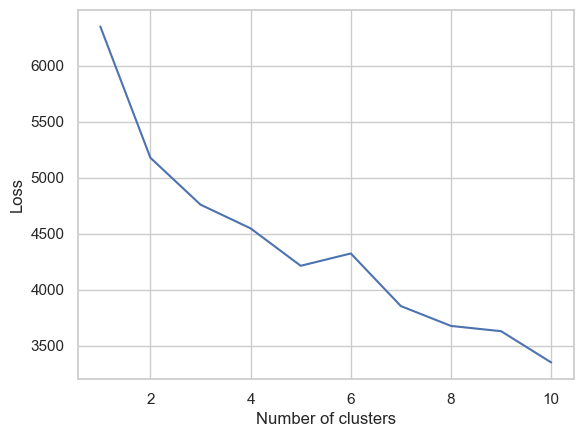

In [673]:
#choose number of cluster centers for k-means++

k_optimal(df_k_optimal, 10)

In [ ]:
#even though 4 and 5 seem more fitting, they yieled no better results than 3 cluster centers, therefore we used 3

In [731]:
#apply k-means++ and gmm
df_clustering_end = df_location_end_scaled_trans.copy()
means = KMeans(n_clusters=4, random_state=42,init="k-means++")
means.fit(df_clustering_end)
gmm = GaussianMixture(n_components = 4, random_state=42)
gmm.fit(df_clustering_end)

numbers_kmeans = ['dinner rides', 'work rides', 'breakfast and lunch break rides', 'latenight rides', 'five', 'six']
numbers_gmm = ['dinner rides', 'afternoon rides', 'latenight rides', 'work rides', 'five', 'six']

#add cluster lables to the dataset
df_cluster_kmeans = means.predict(location_end_scaled_trans)
df_cluster_gmm = gmm.predict(location_end_scaled_trans)

df_clustering_end["kmeans_cluster"] = df_cluster_kmeans
df_clustering_end["kmeans_cluster"] = df_clustering_end["kmeans_cluster"].apply(lambda x: numbers_kmeans[x])
df_clustering_end["gmm_cluster"] = df_cluster_gmm
df_clustering_end["gmm_cluster"] = df_clustering_end["gmm_cluster"].apply(lambda x: numbers_gmm[x])



In [733]:
cluster_sizes_kmeans_end = df_clustering_end.groupby(['kmeans_cluster'])['kmeans_cluster'].agg('count')
cluster_sizes_gmm_end = df_clustering_end.groupby(['gmm_cluster'])['gmm_cluster'].agg('count')
print(cluster_sizes_kmeans_end)
print(cluster_sizes_gmm_end)

kmeans_cluster
breakfast and lunch break rides     65
dinner rides                        82
latenight rides                    133
work rides                          61
Name: kmeans_cluster, dtype: int64
gmm_cluster
afternoon rides     99
dinner rides        35
latenight rides    154
work rides          53
Name: gmm_cluster, dtype: int64


In [734]:
#sort stations into respective cluster dataframes
df_stations_one = df_clustering_end.loc[df_clustering_end['kmeans_cluster'] == 'dinner rides']
df_stations_two = df_clustering_end.loc[df_clustering_end['kmeans_cluster'] == 'work rides']
df_stations_three = df_clustering_end.loc[df_clustering_end['kmeans_cluster'] == 'breakfast and lunch break rides']
df_stations_four = df_clustering_end.loc[df_clustering_end['kmeans_cluster'] == 'latenight rides']


#gmm
df_stations_one_gmm = df_clustering_end.loc[df_clustering_end['gmm_cluster'] == 'dinner rides']
df_stations_two_gmm = df_clustering_end.loc[df_clustering_end['gmm_cluster'] == 'afternoon rides']
df_stations_three_gmm = df_clustering_end.loc[df_clustering_end['gmm_cluster'] == 'latenight rides']
df_stations_four_gmm = df_clustering_end.loc[df_clustering_end['gmm_cluster'] == 'work rides']

#drop the cluster column as its not needed anymore
df_stations_one = df_stations_one.drop(['kmeans_cluster','gmm_cluster'], axis = 1)
df_stations_two = df_stations_two.drop(['kmeans_cluster','gmm_cluster'], axis = 1)
df_stations_three = df_stations_three.drop(['kmeans_cluster','gmm_cluster'], axis = 1)
df_stations_four = df_stations_four.drop(['kmeans_cluster','gmm_cluster'], axis = 1)


#gmm
df_stations_one_gmm = df_stations_one_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)
df_stations_two_gmm = df_stations_two_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)
df_stations_three_gmm = df_stations_three_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)
df_stations_four_gmm = df_stations_four_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)

#transpose and calculate average over every hour of the day 
df_stations_one = df_stations_one.transpose()
df_stations_two = df_stations_two.transpose()
df_stations_three = df_stations_three.transpose()
df_stations_four = df_stations_four.transpose()

df_stations_one['average'] = df_stations_one.mean(numeric_only = True, axis = 1)
df_stations_two['average'] = df_stations_two.mean(numeric_only = True, axis = 1)
df_stations_three['average'] = df_stations_three.mean(numeric_only = True, axis = 1)
df_stations_four['average'] = df_stations_four.mean(numeric_only = True, axis = 1)


#gmm
df_stations_one_gmm = df_stations_one_gmm.transpose()
df_stations_two_gmm = df_stations_two_gmm.transpose()
df_stations_three_gmm = df_stations_three_gmm.transpose()
df_stations_four_gmm = df_stations_four_gmm.transpose()


df_stations_one_gmm['average'] = df_stations_one_gmm.mean(numeric_only = True, axis = 1)
df_stations_two_gmm['average'] = df_stations_two_gmm.mean(numeric_only = True, axis = 1)
df_stations_three_gmm['average'] = df_stations_three_gmm.mean(numeric_only = True, axis = 1)
df_stations_four_gmm['average'] = df_stations_four_gmm.mean(numeric_only = True, axis = 1)


(None,
 Text(0.5, 1.0, 'Cluster 4: latenight rides'),
 Text(781.5909090909089, 0.5, 'Trips'),
 Text(0.5, 44.249999999999986, 'Start Hour'))

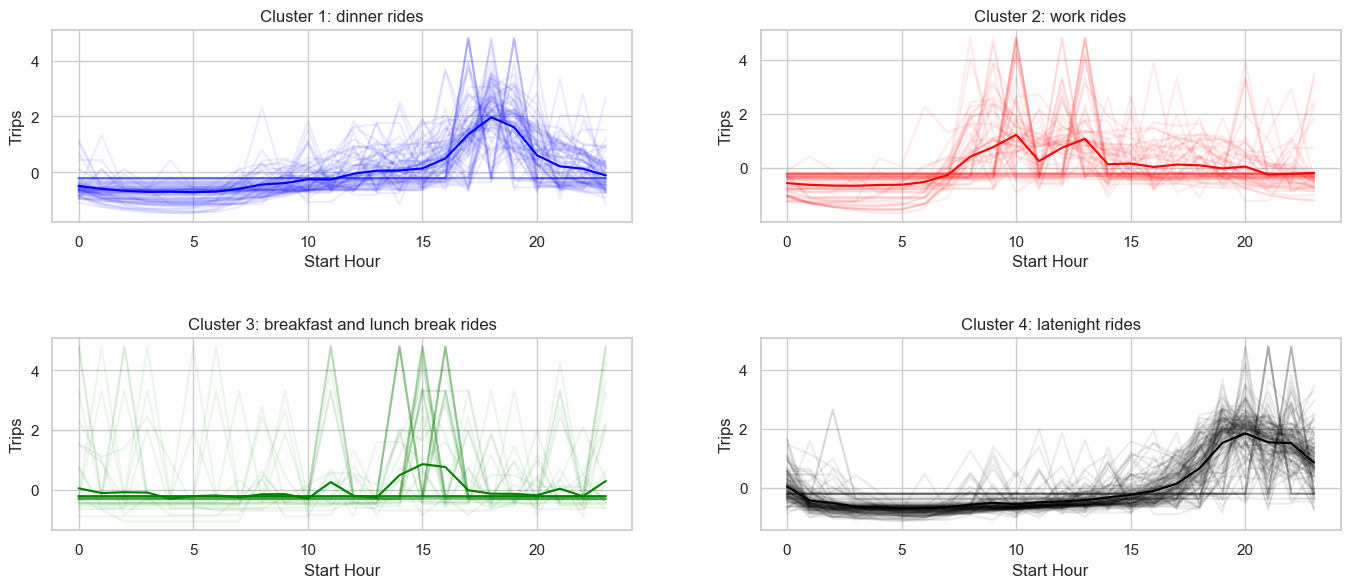

In [739]:
#plot the results kmeans
fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize=(15,7))
fig.tight_layout(pad = 5)

df_stations_one.plot(ax=ax[0,0],color='blue', alpha=0.08)
df_stations_one["average"].plot(ax=ax[0,0],color='blue', alpha=1)
ax[0,0].get_legend().remove(), ax[0,0].set_title('Cluster 1: dinner rides'), ax[0,0].set_ylabel('Trips'), ax[0,0].set_xlabel('Start Hour')

df_stations_two.plot(ax=ax[0,1],color='red', alpha=0.08)
df_stations_two["average"].plot(ax=ax[0,1],color='red', alpha=1)
ax[0,1].get_legend().remove(), ax[0,1].set_title('Cluster 2: work rides'), ax[0,1].set_ylabel('Trips'), ax[0,1].set_xlabel('Start Hour')

df_stations_three.plot(ax=ax[1,0],color='green', alpha=0.08)
df_stations_three["average"].plot(ax=ax[1,0],color='green', alpha=1)
ax[1,0].get_legend().remove(), ax[1,0].set_title('Cluster 3: breakfast and lunch break rides'), ax[1,0].set_ylabel('Trips'), ax[1,0].set_xlabel('Start Hour')

df_stations_four.plot(ax=ax[1,1],color='black', alpha=0.08)
df_stations_four["average"].plot(ax=ax[1,1],color='black', alpha=1)
ax[1,1].get_legend().remove(), ax[1,1].set_title('Cluster 4: latenight rides'), ax[1,1].set_ylabel('Trips'), ax[1,1].set_xlabel('Start Hour')


(None,
 Text(0.5, 1.0, 'Cluster 4: work rides'),
 Text(781.5909090909089, 0.5, 'Trips'),
 Text(0.5, 44.249999999999986, 'Start Hour'))

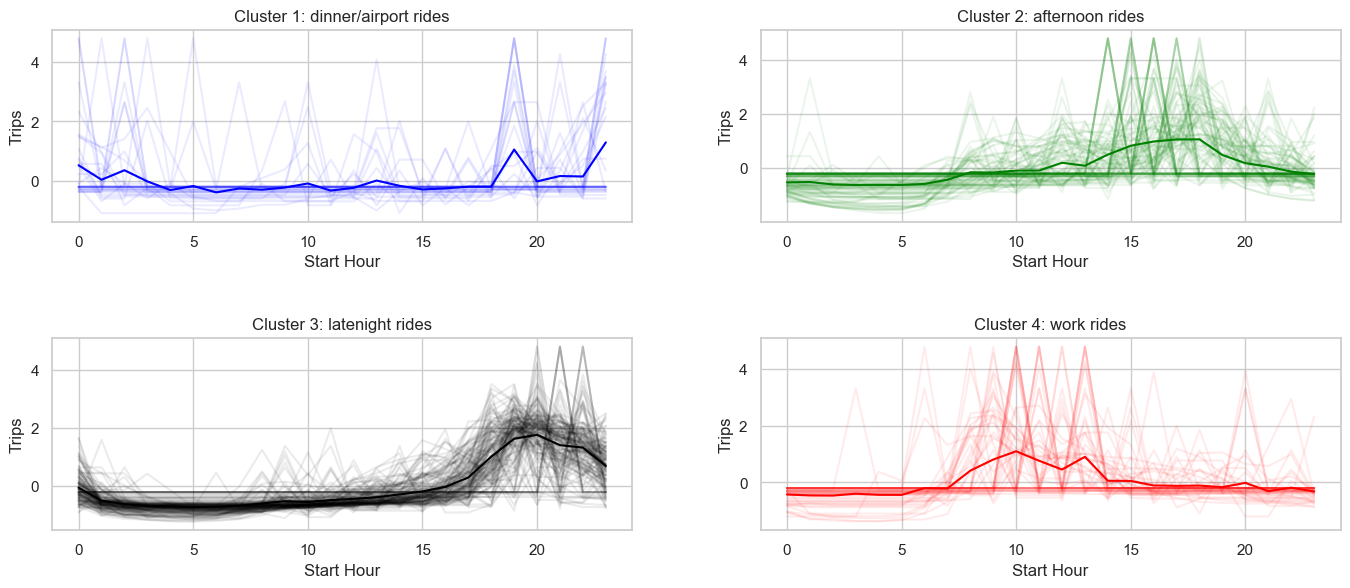

In [740]:
#plot the results gmm
fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize=(15,7))
fig.tight_layout(pad = 5)

df_stations_one_gmm.plot(ax=ax[0,0],color='blue', alpha=0.08)
df_stations_one_gmm["average"].plot(ax=ax[0,0],color='blue', alpha=1)
ax[0,0].get_legend().remove(), ax[0,0].set_title('Cluster 1: dinner/airport rides'), ax[0,0].set_ylabel('Trips'), ax[0,0].set_xlabel('Start Hour')

df_stations_two_gmm.plot(ax=ax[0,1],color='green', alpha=0.08)
df_stations_two_gmm["average"].plot(ax=ax[0,1],color='green', alpha=1)
ax[0,1].get_legend().remove(), ax[0,1].set_title('Cluster 2: afternoon rides'), ax[0,1].set_ylabel('Trips'), ax[0,1].set_xlabel('Start Hour')

df_stations_three_gmm.plot(ax=ax[1,0],color='black', alpha=0.08)
df_stations_three_gmm["average"].plot(ax=ax[1,0],color='black', alpha=1)
ax[1,0].get_legend().remove(), ax[1,0].set_title('Cluster 3: latenight rides'), ax[1,0].set_ylabel('Trips'), ax[1,0].set_xlabel('Start Hour')

df_stations_four_gmm.plot(ax=ax[1,1],color='red', alpha=0.08)
df_stations_four_gmm["average"].plot(ax=ax[1,1],color='red', alpha=1)
ax[1,1].get_legend().remove(), ax[1,1].set_title('Cluster 4: work rides'), ax[1,1].set_ylabel('Trips'), ax[1,1].set_xlabel('Start Hour')

In [741]:
# spatial visualization preperation

# retrieve hexagon ID thorugh row index for each hexagon
df_clustering_end['agg_hex_id'] = df_clustering_end.index

# Add geometries (POLYGON) to dataframe by querying the h3 hexagon boundaries 
df_clustering_end['geometry'] = df_clustering_end['agg_hex_id'].apply(lambda id: Polygon(h3.h3_to_geo_boundary(id, geo_json=True)))

# create geodataframe for visualization  by extracting geometry of each hexagon and corresponding cluster assginments
df_viz_kmeans = geopandas.GeoDataFrame(df_clustering_end[['geometry', 'kmeans_cluster']], crs='EPSG:4326')
df_viz_gmm = geopandas.GeoDataFrame(df_clustering_end[['geometry', 'gmm_cluster']], crs='EPSG:4326')

In [743]:
df_viz_kmeans.explore(column = 'kmeans_cluster', cmap = ['green', 'blue', 'black', 'red'])

In [744]:
df_viz_gmm.explore(column = 'gmm_cluster', cmap = ['green', 'blue', 'black', 'red'])